<a href="https://colab.research.google.com/github/dduwa/ocular-disease-recognition/blob/main/VGG16_ODIR5K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
import os

from concurrent.futures import ThreadPoolExecutor

import ast
import seaborn as sns

# Access Dataset via Kaggle API
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem.

In [2]:
from google.colab import files
uploaded = files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pyparsing/core.py", line 4114, in parseImpl
    return e._parse(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pyparsing/core.py", line 821, in _parseNoCache
    loc, tokens = self.parseImpl(instring, pre_loc, doActions)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pyparsing/core.py", line 2341, in parseImpl
    raise ParseException(instring, loc, self.errmsg, self)
pip._vendor.pyparsing.exceptions.ParseException: Expected 'python_impleme

# Loading the Dataset

In [3]:
df_data = pd.read_csv('full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Dataset Information

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

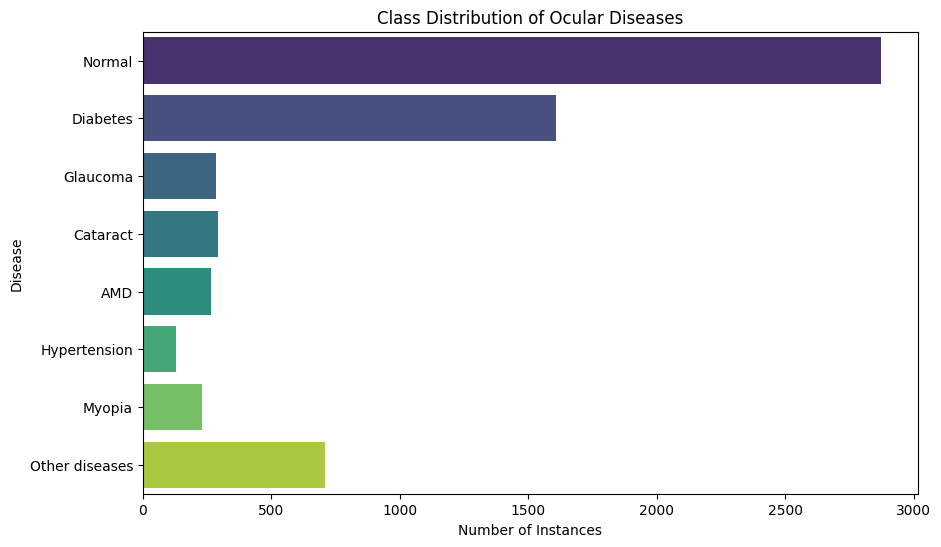

In [16]:
import ast
# Define the class labels as provided by the user
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
df_data['class_name'] = df_data['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = df_data['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the class distribution using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.values, y=class_counts.index, hue=class_counts.index, palette="viridis", legend=False)
plt.title('Class Distribution of Ocular Diseases')
plt.xlabel('Number of Instances')
plt.ylabel('Disease')
plt.show()


# Loading the Training Data

In [ ]:
print(type(df_data['target'].iloc[0]))


<class 'str'>


In [4]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and validation sets
train_df, test_df = train_test_split(df_data, test_size=0.2, random_state=123)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=123)
# Function to load and preprocess images
def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.vgg16.preprocess_input(image)  # Preprocessing the image to be compatible with VGG16
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)  # Remove brackets
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label

def load_and_prepare_dataset(df, images_dir, shuffle=True, batch_size=32, augment_data=False):


    # Assuming images_dir is the base directory for the images and concatenating it with image filenames
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    # Assuming 'target' column contains labels in a string format that needs to be parsed
    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset


# Creating training and validation datasets
train_ds = load_and_prepare_dataset(train_df, 'ODIR-5K/ODIR-5K/Training Images/', shuffle=True, batch_size=16)
test_ds = load_and_prepare_dataset(test_df, 'ODIR-5K/ODIR-5K/Training Images/', shuffle=False, batch_size=16)
val_ds = load_and_prepare_dataset(val_df, 'ODIR-5K/ODIR-5K/Training Images/', shuffle=False, batch_size=16)



In [5]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))
print("size of testing dataset: ", len(test_ds) )

size of training dataset:  512
size of validation dataset:  128
size of testing dataset:  160


# Visualising the training and validation datasets




Training dataset
(16, 224, 224, 3)
(16, 8)


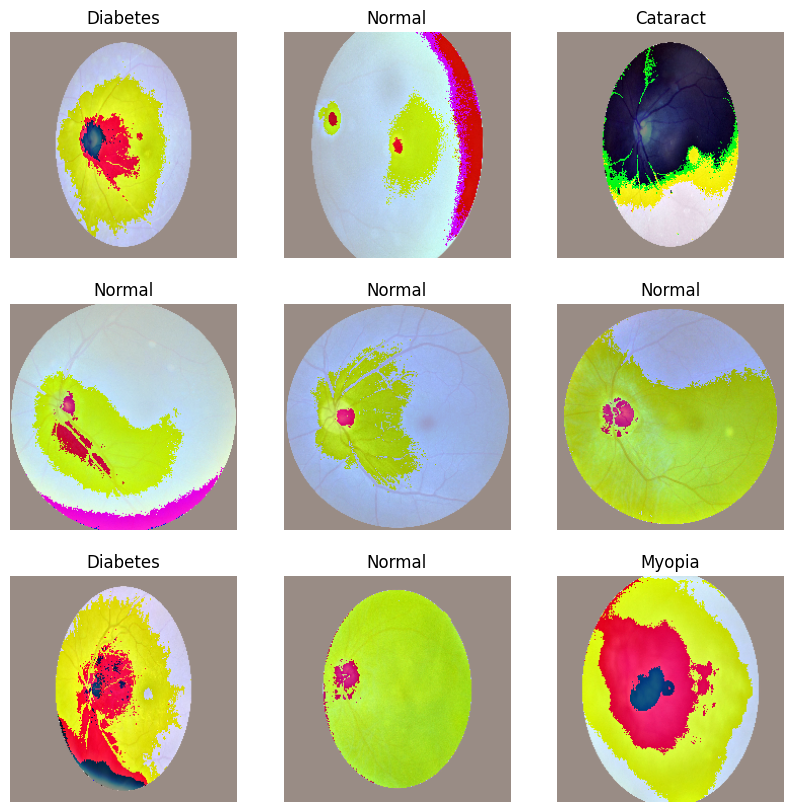

In [6]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")


Validation dataset
(16, 224, 224, 3)
(16, 8)


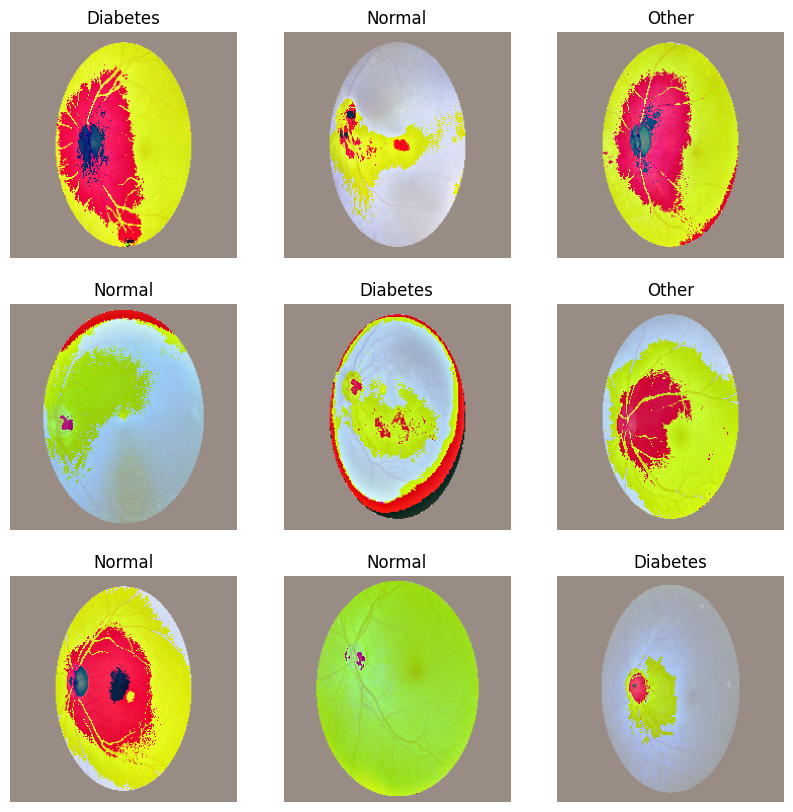

In [21]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

# Training the model

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)


callbacks = [early_stopping, checkpoint, reduce_lr]

Attention Mechanism

In [25]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Multiply, Dropout, BatchNormalization

class SqueezeExciteBlock(tf.keras.layers.Layer):
    def __init__(self, ratio=16, **kwargs):
        super(SqueezeExciteBlock, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        self.channel_axis = -1
        self.filters = input_shape[self.channel_axis]
        self.se_shape = (1, 1, self.filters)

        self.squeeze = GlobalAveragePooling2D()
        self.reshape = Reshape(self.se_shape)
        self.reduce_dim = Dense(self.filters // self.ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.excite = Dense(self.filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)
        super(SqueezeExciteBlock, self).build(input_shape)

    def call(self, inputs):
        x = self.squeeze(inputs)
        x = self.reshape(x)
        x = self.reduce_dim(x)
        x = self.excite(x)
        return Multiply()([inputs, x])

    def compute_output_shape(self, input_shape):
        return input_shape

In [9]:
# Load the VGG16 model, pre-trained on ImageNet data
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling=None,  # Changed to None to apply attention mechanism
    weights='imagenet'
)

# Freeze the layers of the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Create the model
model = Sequential()
model.add(pretrained_model)

# Add Squeeze-and-Excitation block for channel-wise attention
model.add(SqueezeExciteBlock())

model.add(GlobalAveragePooling2D())  # Replace Flatten with GlobalAveragePooling2D for dimensionality reduction
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout layer to reduce overfitting
model.add(Dense(8, activation='softmax'))  # Use num_classes for generalizability

# Compile the model with a custom learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 squeeze_excite_block (Sque  (None, 7, 7, 512)         32768     
 ezeExciteBlock)                                                 
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2

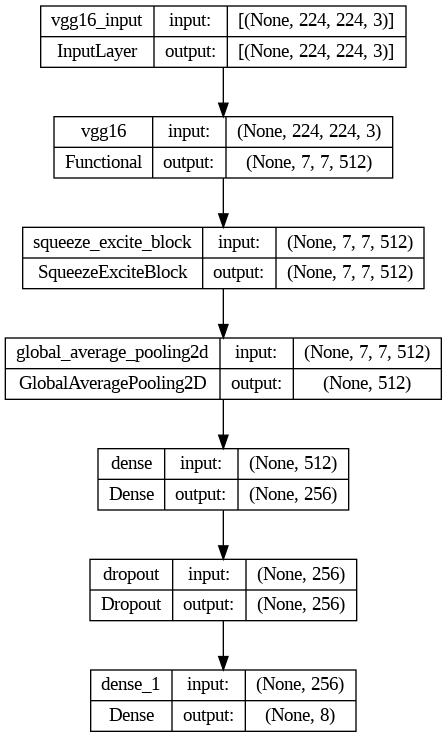

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
epochs = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/50
512/512 [==============================] - ETA: 0s - loss: 1.5031 - accuracy: 0.4746
Epoch 1: val_loss improved from inf to 1.32938, saving model to best_model
512/512 [==============================] - 55s 66ms/step - loss: 1.5031 - accuracy: 0.4746 - val_loss: 1.3294 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 2/50
512/512 [==============================] - ETA: 0s - loss: 1.3062 - accuracy: 0.5268
Epoch 2: val_loss improved from 1.32938 to 1.30296, saving model to best_model
512/512 [==============================] - 47s 62ms/step - loss: 1.3062 - accuracy: 0.5268 - val_loss: 1.3030 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 3/50
510/512 [============================>.] - ETA: 0s - loss: 1.2511 - accuracy: 0.5422
Epoch 3: val_loss improved from 1.30296 to 1.28420, saving model to best_model
512/512 [==============================] - 47s 62ms/step - loss: 1.2512 - accuracy: 0.5419 - val_loss: 1.2842 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 4/50
512/512 [=====================

# Evaluating Model
- Model Accuracy
- Model Loss


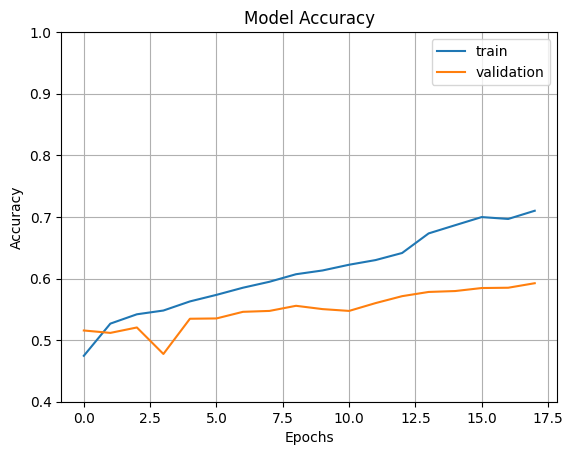

In [13]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

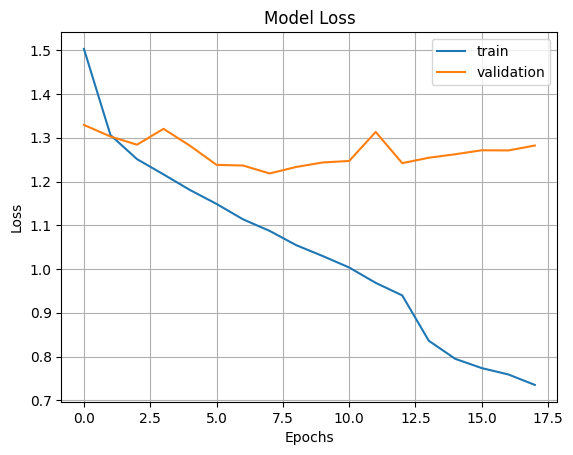

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [26]:
# Unfreeze the last block of the VGG16 model
for layer in pretrained_model.layers[-4:]:  # Unfreezes the last conv block
    layer.trainable = True

# Modify model to include Batch Normalization
model = Sequential()
model.add(pretrained_model)
model.add(BatchNormalization())  # Add batch normalization
model.add(SqueezeExciteBlock())
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())  # Add batch normalization before dropout
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

# Compile the model with a smaller learning rate for fine-tuning
optimizer = Adam(learning_rate=0.0001)  # Smaller learning rate for fine-tuning
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
epochs = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/50
512/512 [==============================] - ETA: 0s - loss: 2.2663 - accuracy: 0.3355
Epoch 1: val_loss did not improve from 1.21846
512/512 [==============================] - 51s 62ms/step - loss: 2.2663 - accuracy: 0.3355 - val_loss: 2.1223 - val_accuracy: 0.2727 - lr: 1.0000e-04
Epoch 2/50
511/512 [============================>.] - ETA: 0s - loss: 1.7205 - accuracy: 0.4610
Epoch 2: val_loss did not improve from 1.21846
512/512 [==============================] - 46s 60ms/step - loss: 1.7205 - accuracy: 0.4609 - val_loss: 2.0467 - val_accuracy: 0.3465 - lr: 1.0000e-04
Epoch 3/50
511/512 [============================>.] - ETA: 0s - loss: 1.4065 - accuracy: 0.5412
Epoch 3: val_loss did not improve from 1.21846
512/512 [==============================] - 46s 59ms/step - loss: 1.4066 - accuracy: 0.5412 - val_loss: 1.9909 - val_accuracy: 0.3734 - lr: 1.0000e-04
Epoch 4/50
511/512 [============================>.] - ETA: 0s - loss: 1.2315 - accuracy: 0.5861
Epoch 4: val_loss did not

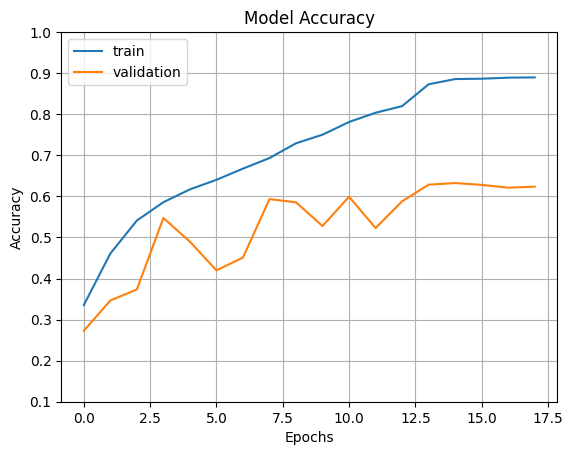

In [39]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

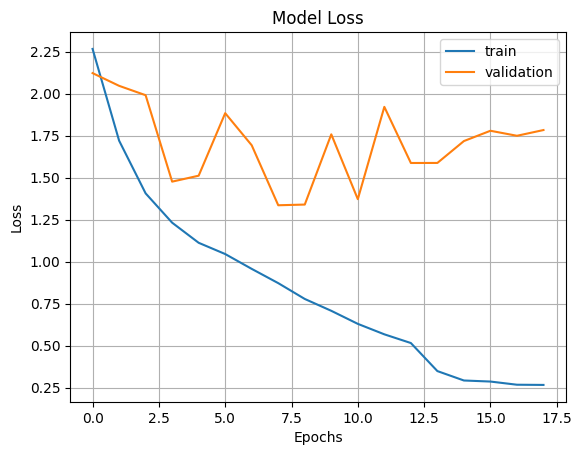

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions


In [28]:
test_ds.take(1)

# Evaluating the model on the test set
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {round(accuracy * 100, 2)}%')

160/160 [==============================] - 9s 53ms/step - loss: 1.2787 - accuracy: 0.6020
Test accuracy: 60.2%


160/160 [==============================] - 9s 55ms/step - loss: 1.2787 - accuracy: 0.6020
Evaluation results: [1.278677225112915, 0.6020328402519226]
160/160 [==============================] - 9s 51ms/step


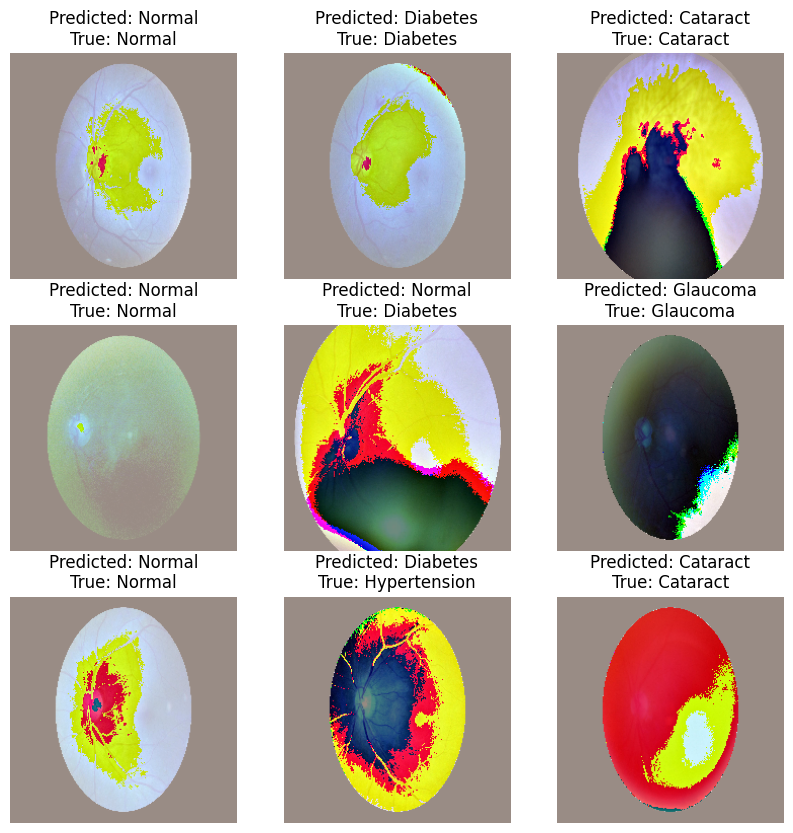

In [29]:
# Evaluate the model on the test dataset
evaluation_results = model.evaluate(test_ds)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Define the number of images you want to display
num_images_to_display = 9

# Initialize lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Prediction Evaluation
- Classes normal, diabetes and others are the top 3 predicted classes, this suggests that the remaining classes are underrepresented hence the model is not using them to classify the test data.

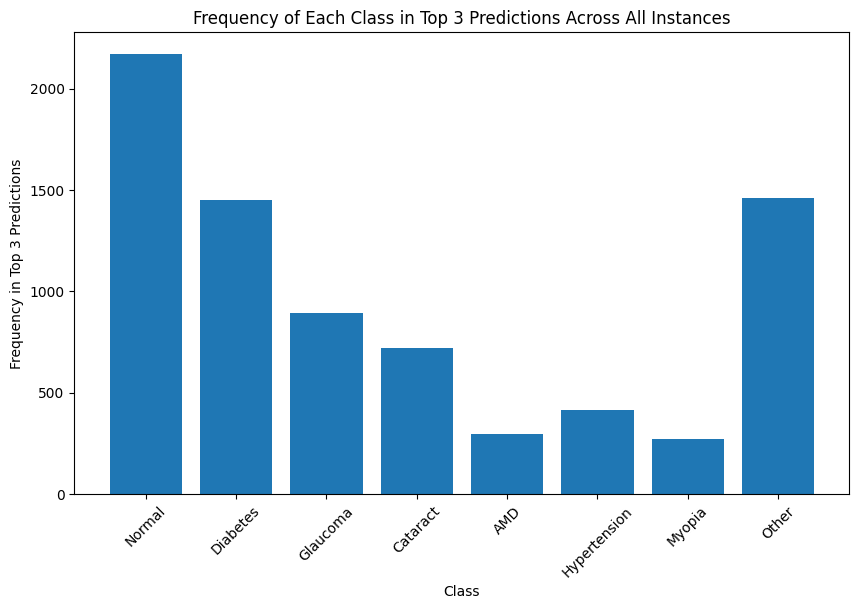

In [30]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [31]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report

In [32]:
for _, label in test_ds.unbatch().take(1):
    print("Unbatched label shape:", label.numpy().shape)
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# true_labels should now be a 2-dimensional array, you can verify by printing its shape
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

Unbatched label shape: (8,)
Shape of true_labels after vstack: (2558, 8)


In [33]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)

                precision    recall  f1-score   support

        Normal       0.63      0.74      0.68      1108
      Diabetes       0.60      0.57      0.58       650
      Glaucoma       0.41      0.54      0.46       114
      Cataract       0.55      0.77      0.64       124
           AMD       0.77      0.62      0.69       100
  Hypertension       0.64      0.32      0.43        56
        Myopia       0.78      0.85      0.81       100
Other diseases       0.28      0.08      0.12       306

      accuracy                           0.60      2558
     macro avg       0.58      0.56      0.55      2558
  weighted avg       0.58      0.60      0.58      2558



Balanced Accuracy Score

In [34]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.5616


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)


In [35]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.8525


Confusion Matrix

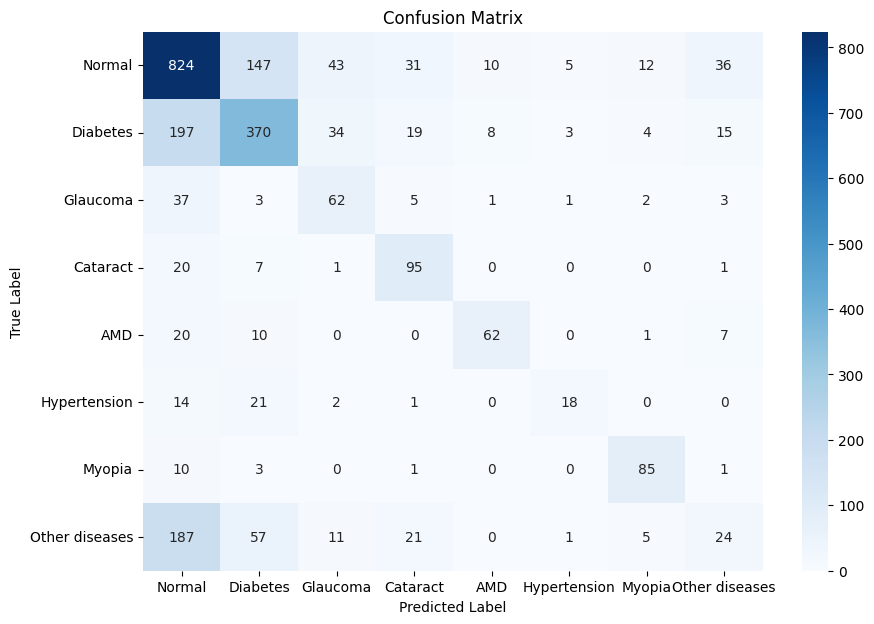

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

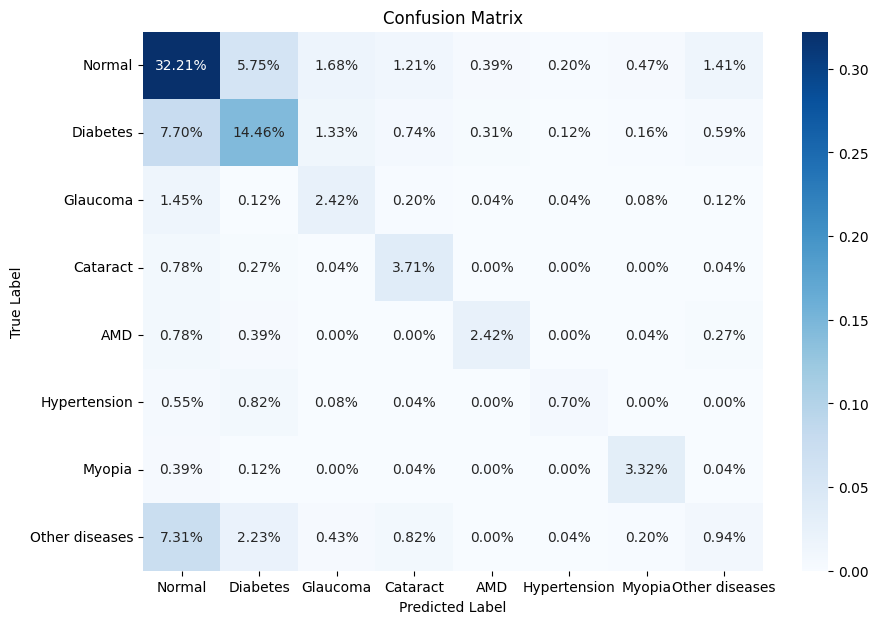

In [37]:
# Calculate normalized confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = cm.astype('float') / cm.sum()

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()